In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from bs4 import BeautifulSoup
from lxml import html
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

### Importing the cleaned data; the data includes energy consumption in MWH for 4 utilities under CAISO- PGE, SCE, VEA and SDGE.  For my capstone project, I will focus only on one utility for now-SDGE (San Diego Gas & Electric); selecting smaller region will make it easier in the future to import the weather data and use it as a forecasting parameter. 

In [2]:
#reading in the hourly energy consumption .csv file imported and cleaned using 
#Capstone1_CAISO_hourly_energy_import&clean_data.ipynb
hSDGE1418=pd.read_csv('hourly1418CA.csv',usecols=['Dates','SDGE'], parse_dates=['Dates'])

In [3]:
#Next few lines: checking the data
hSDGE1418.head()

Dates    SDGE
0 2014-01-01 00:00:00  2096.0
1 2014-01-01 01:00:00  1986.0
2 2014-01-01 02:00:00  1936.0
3 2014-01-01 03:00:00  1896.0
4 2014-01-01 04:00:00  1899.0

In [4]:
hSDGE1418.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 2 columns):
Dates    43824 non-null datetime64[ns]
SDGE     43824 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 684.8 KB


In [5]:
hSDGE1418.describe()

SDGE
count  43824.000000
mean    2364.928692
std      481.066444
min     1437.081129
25%     1995.046696
50%     2298.000000
75%     2622.000000
max     4867.000000

In [6]:
#Since the date column is in object format, converting the Dates column to datetime 
#hSDGE1418['Dates']=pd.to_datetime(hSDGE1418['Dates'])
#checking info again
#hSDGE1418.info()

In [7]:
#Adding weekdays, month, day of the month, hour of the day, year as extra columns; mapping the weekdays to a dict
#to use the actual weekdays in words like 'Monday', etc. Python usually indicates Monday as 0, Tuesday as 1 and so on. 
weekdays={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
hSDGE1418['Date']= pd.to_datetime(hSDGE1418.Dates.dt.date)
hSDGE1418['year']=hSDGE1418.Dates.dt.year
hSDGE1418['month']=hSDGE1418.Dates.dt.month
hSDGE1418['day']=hSDGE1418.Dates.dt.day
hSDGE1418['hour']=hSDGE1418.Dates.dt.hour
hSDGE1418['weekday']=hSDGE1418.Dates.dt.weekday.map(weekdays)

In [8]:
#Checking the data
hSDGE1418.head()

Dates    SDGE       Date  year  month  day  hour    weekday
0 2014-01-01 00:00:00  2096.0 2014-01-01  2014      1    1     0  Wednesday
1 2014-01-01 01:00:00  1986.0 2014-01-01  2014      1    1     1  Wednesday
2 2014-01-01 02:00:00  1936.0 2014-01-01  2014      1    1     2  Wednesday
3 2014-01-01 03:00:00  1896.0 2014-01-01  2014      1    1     3  Wednesday
4 2014-01-01 04:00:00  1899.0 2014-01-01  2014      1    1     4  Wednesday

In [9]:
hSDGE1418.tail()

Dates         SDGE       Date  year  month  day  hour  \
43819 2018-12-31 19:00:00  2609.685890 2018-12-31  2018     12   31    19   
43820 2018-12-31 20:00:00  2504.283858 2018-12-31  2018     12   31    20   
43821 2018-12-31 21:00:00  2389.460971 2018-12-31  2018     12   31    21   
43822 2018-12-31 22:00:00  2259.741640 2018-12-31  2018     12   31    22   
43823 2018-12-31 23:00:00  2123.183153 2018-12-31  2018     12   31    23   

      weekday  
43819  Monday  
43820  Monday  
43821  Monday  
43822  Monday  
43823  Monday

In [10]:
#Adding holidays column to indicate whether a day was a holiday as per the US calendar or not
cal = calendar()
holidays = cal.holidays(start=hSDGE1418['Date'].min(), end=hSDGE1418['Date'].max())
hSDGE1418['holiday'] = hSDGE1418['Date'].isin(holidays)

In [11]:
#checking if holidays were mapped correctly; True should indicate a holiday and False a regular day. Also, if a holiday falls 
#on a weekend it is not marked as a holiday, so the value will be False. 
#hSDGE1418[(hSDGE1418.month==12) & (hSDGE1418.day==25)] #checking the specific holiday of 25th Dec
#hSDGE1418.head()

In [12]:
#converting the holiday column to 1 and 0, 1 indicating a holiday and 0 not a holiday; using dictionary and map to achieve this
mapped={True:1, False:0}
hSDGE1418.holiday=hSDGE1418.holiday.map(mapped)
hSDGE1418.head()

Dates    SDGE       Date  year  month  day  hour    weekday  \
0 2014-01-01 00:00:00  2096.0 2014-01-01  2014      1    1     0  Wednesday   
1 2014-01-01 01:00:00  1986.0 2014-01-01  2014      1    1     1  Wednesday   
2 2014-01-01 02:00:00  1936.0 2014-01-01  2014      1    1     2  Wednesday   
3 2014-01-01 03:00:00  1896.0 2014-01-01  2014      1    1     3  Wednesday   
4 2014-01-01 04:00:00  1899.0 2014-01-01  2014      1    1     4  Wednesday   

   holiday  
0        1  
1        1  
2        1  
3        1  
4        1

In [13]:
#adding in another column which indicates 'non-working' days which include weekends and holidays
hSDGE1418['non_working']=hSDGE1418.apply(lambda x: 1 if \
                                         ((x['holiday']==1) or (x['weekday'] in ['Saturday', 'Sunday']))
                                         else 0, axis=1)

In [14]:
hSDGE1418.head()

Dates    SDGE       Date  year  month  day  hour    weekday  \
0 2014-01-01 00:00:00  2096.0 2014-01-01  2014      1    1     0  Wednesday   
1 2014-01-01 01:00:00  1986.0 2014-01-01  2014      1    1     1  Wednesday   
2 2014-01-01 02:00:00  1936.0 2014-01-01  2014      1    1     2  Wednesday   
3 2014-01-01 03:00:00  1896.0 2014-01-01  2014      1    1     3  Wednesday   
4 2014-01-01 04:00:00  1899.0 2014-01-01  2014      1    1     4  Wednesday   

   holiday  non_working  
0        1            1  
1        1            1  
2        1            1  
3        1            1  
4        1            1

### Data exploration
#### Plotting some graphs to get insights from the data. Some of the questions that can be answered are:
##### 1. Checking how the energy  consumption varies across any particular day averaged over the entire period. Typical average daily load profile would be a curve peaking at the evening time because most people return home from work during evening and turn on their lights, TV, AC, etc..
##### 2. Plotting monthly average load profiles. San Diego has hot summers but the winters are not that cold so we can expect the load to be higher in summers because of the cooling load on the commercial and residential buildings.
##### 3. Checking if the average monthly consumption values have increased over the years. 
##### 4. Checking how the energy consumption varies for weekdays vs the weekends or the holidays 
##### 5. Checking hourly vs weekday energy consumption map to get an overall idea of the consumption pattern during a typical week.

#### Plotting average hourly load profile over the entire period

(0, 3355.336797899487)

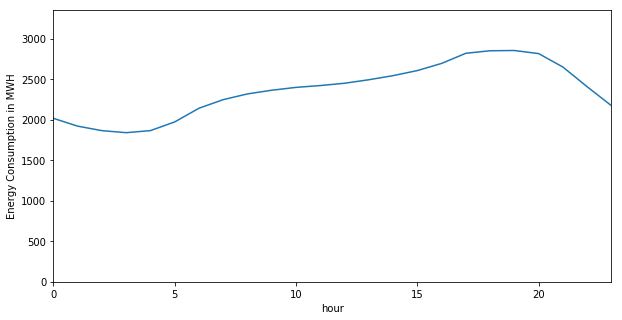

In [15]:
#Plotting average hourly load profile observed over the entire period 
hSDGE1418.groupby('hour')['SDGE'].mean().plot(figsize=(10,5))
plt.ylabel('Energy Consumption in MWH')
plt.ylim([0,max(hSDGE1418.groupby('hour')['SDGE'].mean())+500])

#### From the above average hourly load profile graph we can observe how the load remains low over the night and then starts increasing as the city wakes up, and continues increasing during the office hours and peaks in the evening when everyone returns home and turns on their equipment. 

#### Plotting average monthly load profile over the entire period 

(0, 3300.0712209250687)

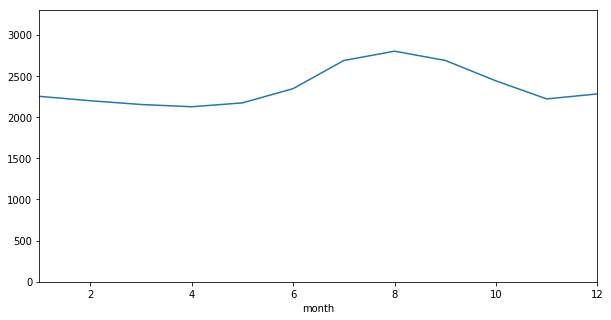

In [16]:
##Plotting average monthly load profile
hSDGE1418.groupby('month')['SDGE'].mean().plot(figsize=(10,5))
plt.ylim([0,max(hSDGE1418.groupby('month')['SDGE'].mean())+500])

#### As expected the monthly load profile peaks in the summer due to high cooling load (caused by high temperatures)

#### Plotting the average monthly energy consumption observed for each month over the past 5 years 

In [17]:
#Grouping the dataframe by month and year by applying groupby with an aggregate function of mean; converting the groupby 
#object into a dataframe
df=hSDGE1418.groupby(['month','year'])['SDGE'].mean()
df=pd.DataFrame(df)

In [18]:
#Unstacking the above dataframe to get the data in a format we can plot
dfun=df.unstack(level='month')
dfun.head()

SDGE                                                      \
month           1            2            3            4            5    
year                                                                     
2014   2289.122312  2287.229167  2237.892473  2256.341667  2435.094086   
2015   2255.966398  2205.293155  2258.916667  2196.484722  2146.177419   
2016   2298.233871  2208.837644  2122.209677  2120.487500  2105.094086   
2017   2239.989221  2148.653488  2084.434493  2030.601724  2113.055748   
2018   2175.139451  2141.691298  2061.274450  2022.019529  2061.729266   

                                                                        \
month           6            7            8            9            10   
year                                                                     
2014   2416.908333  2756.000000  2803.717742  2939.491667  2521.405914   
2015   2412.219444  2578.725806  2848.950269  2955.175000  2656.813172   
2016   2417.443056  2649.155914  2723.741935  2507.890278  2347.349462   
2017   2299.035590  2668.690458  2660.980782  2577.793395  2410.197772   
2018   2179.901757  2781.200171  2962.965377  2458.121081  2262.201133   

                                 
month           11           12  
year                             
2014   2231.704167  2308.564516  
2015   2252.494444  2372.629032  
2016   2244.836111  2262.787634  
2017   2200.686648  2240.598360  
2018   2173.380679  2221.340664

In [19]:
#resetting the index to get year as a column 
dfun.reset_index(inplace=True)

In [20]:
#Melting the above dataframe to get the data in the required format to plot average monthly consumption for each month over the 
#past 5 years 
melt=pd.melt(dfun, id_vars='year', value_name='Avg. monthly energy consumption MWH')
melt.head()

year   NaN month  Avg. monthly energy consumption MWH
0  2014  SDGE     1                          2289.122312
1  2015  SDGE     1                          2255.966398
2  2016  SDGE     1                          2298.233871
3  2017  SDGE     1                          2239.989221
4  2018  SDGE     1                          2175.139451

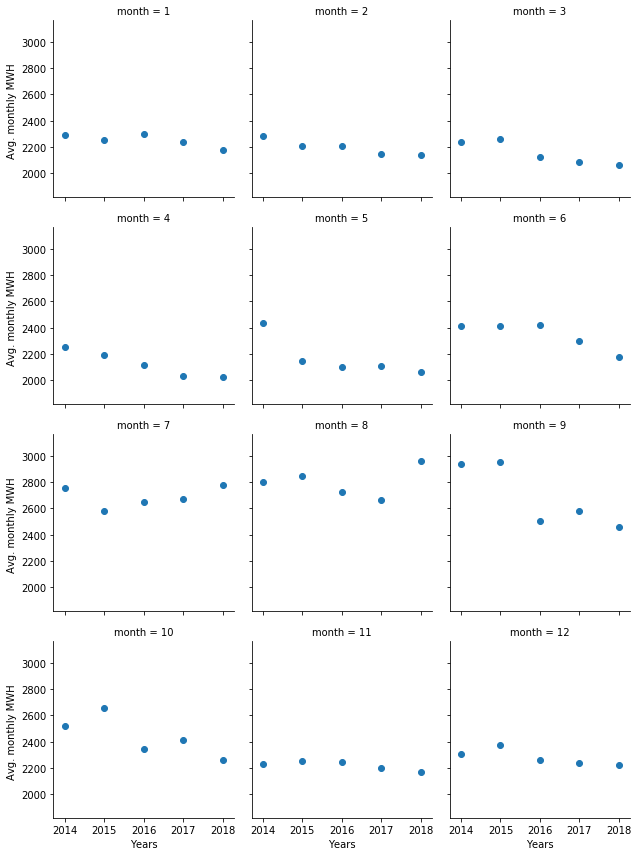

In [21]:
#Plotting each month as a separate graph using Facetgrid
g = sns.FacetGrid(melt, col="month", margin_titles=True, col_wrap=3)
g.map(plt.scatter, "year" ,"Avg. monthly energy consumption MWH");
g.set_axis_labels("Years", "Avg. monthly MWH ");
g.set(ylim=(melt['Avg. monthly energy consumption MWH'].min()-200, melt['Avg. monthly energy consumption MWH'].max()+200));

#### A weak trend can be observed in the data, but it is different for different months. For example, April, May, June, September and October months show a considerable downward trend, whereas other months not so much.

#### Plotting a map of hourly vs weekdays energy consumption to see how the consumption varies across the week

In [22]:
#Using pivot table to create a dataframe having index as hours and columns as weekday and each cell will contain the average
#energy consumption for that particular hour of the weekday
hour_weekday=hSDGE1418.pivot_table(values='SDGE',index='hour', columns='weekday', aggfunc='mean')

In [23]:
#Ordering the weekdays from Monday to Sunday because the default ordering done by the pivot table is alphabetical
hour_weekday=hour_weekday[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

Text(0.5,1,'Average energy consumption in MWH for each hour of each weekday over the entire period')

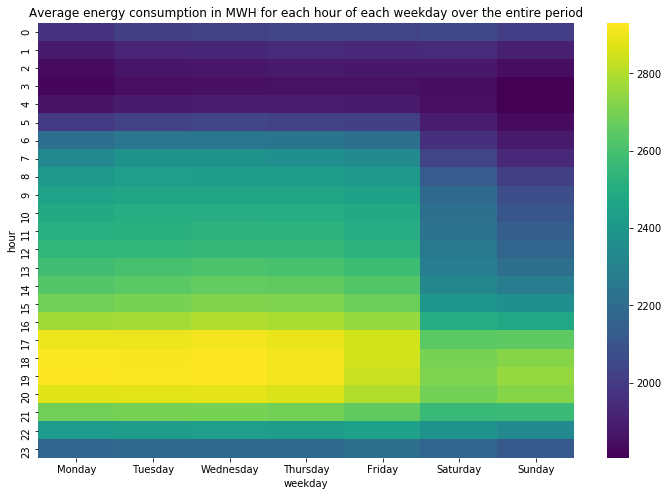

In [24]:
#plotting a heatmap with a colorbar; the colorbar shows the energy consumption in MWH
plt.figure(figsize=(12,8))
sns.heatmap(hour_weekday, cmap='viridis')
plt.title('Average energy consumption in MWH for each hour of each weekday over the entire period')


#### It can be seen that the average consumption from Monday to Friday is below 2000 in the night and it increases during the day and is at peak (>2800) during the evening time before sliding down again for the night. And on the weekends the same pattern can be observed but the overall consumption seems lower on weekends than weekdays as expected because most of the commercial buildings don't operate on weekends (also maybe because people go out on weekends and are not usually at home?)




#### Plotting a histogram to see the overall distribution of the energy consumption for SDGE territory 

C:\Users\ppawar\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


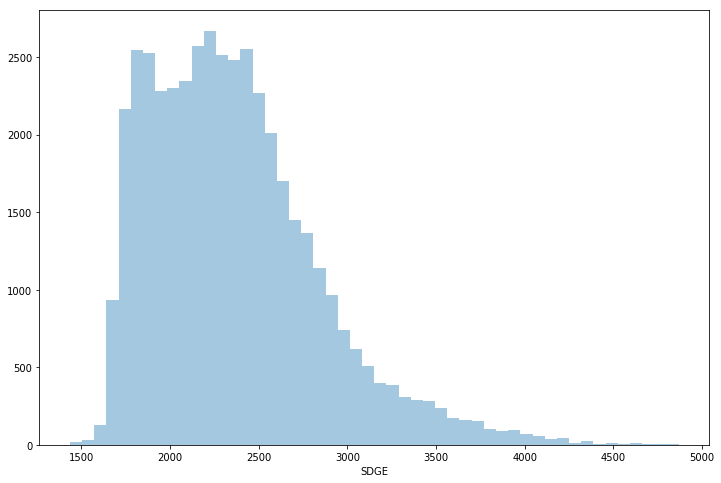

In [25]:
plt.figure(figsize=(12,8))
sns.distplot(hSDGE1418['SDGE'], kde=False)

#### It can be seen that most of the days (for 2014-18) have energy consumption between ~1700 to ~2500 MWH and the maximum the demand goes is till ~4800MWH

#### Plotting the distribution again but this time using the violon plot and dividing the columns of the plot on the weekdays and adding a hue for working and non-working days

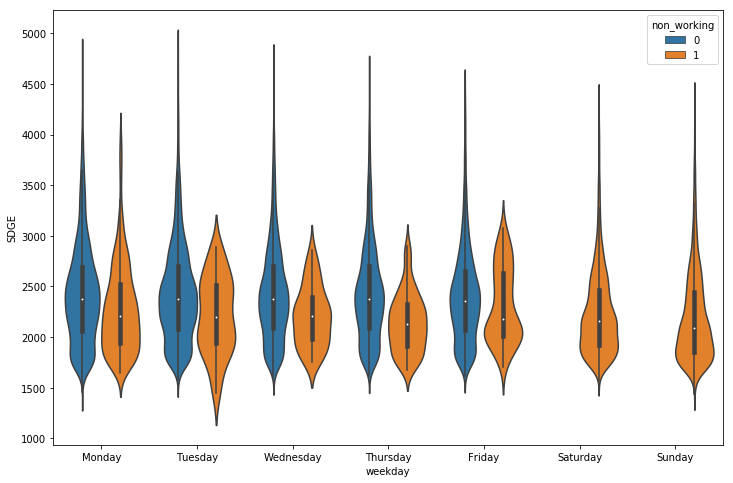

In [26]:
plt.figure(figsize=(12,8))
sns.violinplot(x='weekday', y='SDGE', data=hSDGE1418, \
               order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], hue='non_working')

#### It can be seen that the median energy consumption remains fairly equal from Monday to Friday and drops on the weekend as seen before in the heatmap. Also, if a particular day is a holiday (indicated in orange) the energy consumption is much lower than if the same day was a working day. 

#### Plotting the same plot as above but this time using box plot and using the months as the x axis. Basically observing the spread and distribution of the energy consumption for each month over the entire period

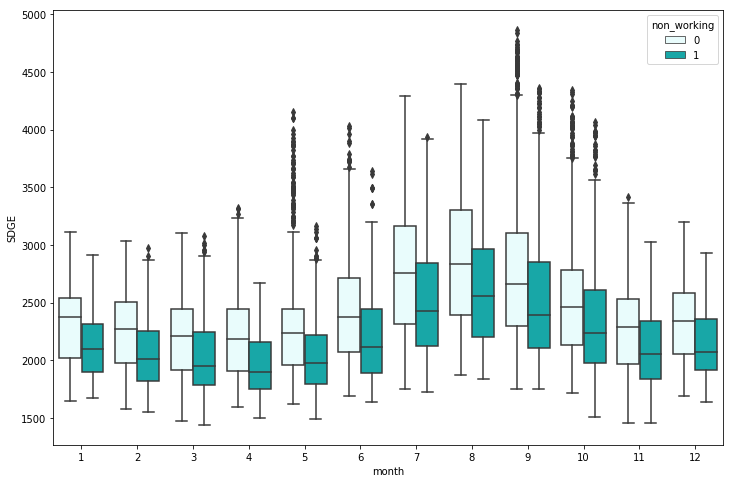

In [27]:
plt.figure(figsize=(12,8))
sns.boxplot(x='month', y='SDGE', data=hSDGE1418, color='c', hue='non_working')

#### As observed before the energy consumption on non-working days (indicated as 1 or dark green) on an average is always lower than that on the working days. Also, the median energy consumption and also the max peak demand on the grid rise in the summer and we can see that the maximum demand was observed in the month of September at around ~4800MW

#### Visualizing the distribution of energy values for different years 

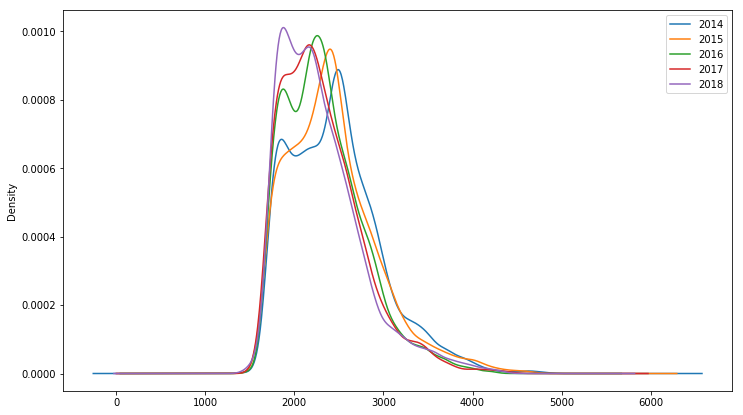

In [37]:
for year in hSDGE1418['year'].unique():
    hSDGE1418[hSDGE1418['year']==year]['SDGE'].plot(kind='density', figsize=(12,7), legend=True, label=year)

#### For all the years the distirubtion is kind of bi-modal and the mode values for energy consumption consistently shifts towards left (towards lower energy load) each year from 2014 to 2018

## Further data exploration:
### Other parameters like weather data can be added to see their effect on the energy consumption. Since it was observed that the summer months have the highest energy load (most probably due to high cooling load requirements), it can be expected that the energy consumption will have some correlation with the outside temperature. This can be tested by importing the weather data for the region over similar period and starting with scatter plots with temperature data on one axis and energy on the other. 